In [1]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

2025-10-27 11:43:02.850587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-27 11:43:02.850612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-27 11:43:02.851623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-27 11:43:02.856705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-27 11:43:03.564814: W tensorflow/compiler/tf2

In [ ]:
root_dir = "datasets"
annotations_dir = os.path.join(root_dir, "annotations")
images_dir = os.path.join(root_dir, "train2014")
tfrecords_dir = os.path.join(root_dir, "tfrecords")
annotation_file = os.path.join(annotations_dir, "captions_train2014.json")

# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip = tf.keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath("."),
        origin="http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
        extract=True,
    )
    os.remove(annotation_zip)

# Download image files
if not os.path.exists(images_dir):
    image_zip = tf.keras.utils.get_file(
        "train2014.zip",
        cache_dir=os.path.abspath("."),
        origin="http://images.cocodataset.org/zips/train2014.zip",
        extract=True,
    )
    os.remove(image_zip)

print("Dataset is downloaded and extracted successfully.")

with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = images_dir + "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

In [2]:
with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = images_dir + "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

Number of images: 82783


In [3]:
train_size = 30000
valid_size = 5000
captions_per_image = 2
images_per_file = 2000

train_image_paths = image_paths[:train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")

valid_image_paths = image_paths[-valid_size:]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

tf.io.gfile.makedirs(tfrecords_dir)


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def create_example(image_path, caption):
    feature = {
        "caption": bytes_feature(caption.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name, image_paths):
    caption_list = []
    image_path_list = []
    for image_path in image_paths:
        captions = image_path_to_caption[image_path][:captions_per_image]
        caption_list.extend(captions)
        image_path_list.extend([image_path] * len(captions))

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(
                image_path_list[example_idx], caption_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1


def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter


train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

  0%|                                                   | 0/15 [00:00<?, ?it/s]2025-10-27 11:43:55.885268: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-27 11:43:55.923188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-27 11:43:55.927255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://gi

60000 training examples were written to tfrecord files.


100%|████████████████████████████████████████████| 3/3 [00:23<00:00,  7.93s/it]

10000 evaluation examples were written to tfrecord files.


In [4]:
feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}


def read_example(example):
    features = tf.io.parse_single_example(example, feature_description)
    raw_image = features.pop("raw_image")
    features["image"] = tf.image.resize(
        tf.image.decode_jpeg(raw_image, channels=3), size=(299, 299)
    )
    return features


def get_dataset(file_pattern, batch_size):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            read_example,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(batch_size * 10)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        .batch(batch_size)
    )

In [5]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [6]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained Xception model to be used as the base encoder.
    xception = keras.applications.Xception(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in xception.layers:
        layer.trainable = trainable
    # Receive the images as inputs.
    inputs = layers.Input(shape=(299, 299, 3), name="image_input")
    # Preprocess the input image.
    xception_input = tf.keras.applications.xception.preprocess_input(inputs)
    # Generate the embeddings for the images using the xception model.
    embeddings = xception(xception_input)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(inputs, outputs, name="vision_encoder")

In [7]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the BERT preprocessing module.
    preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",
        name="text_preprocessing",
    )
    # Load the pre-trained BERT model to be used as the base encoder. Set name = "bert"
    bert = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        name = "bert",
    )
    # Set the trainability of the base encoder.
    bert.trainable = trainable
    # Receive the text as inputs.
    inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
    # Preprocess the text.
    bert_inputs = preprocess(inputs)
    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(bert_inputs)["pooled_output"]
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

In [8]:
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
        super().__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        # Place each encoder on a separate GPU (if available).
        # TF will fallback on available devices if there are fewer than 2 GPUs.
        with tf.device("/gpu:0"):
            # Get the embeddings for the captions.
            caption_embeddings = text_encoder(features["caption"], training=training)
        with tf.device("/gpu:1"):
            # Get the embeddings for the images.
            image_embeddings = vision_encoder(features["image"], training=training)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (captions_similarity + images_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [11]:
num_epochs = 5  # In practice, train for at least 30 epochs
batch_size = 10  #SET THIS ACCORDINGLY

vision_encoder = create_vision_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
text_encoder = create_text_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [12]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (caption-image pairs): {train_example_count}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_example_count / batch_size))}")
train_dataset = get_dataset(os.path.join(tfrecords_dir, "train-*.tfrecord"), batch_size)
valid_dataset = get_dataset(os.path.join(tfrecords_dir, "valid-*.tfrecord"), batch_size)
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = dual_encoder.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping],
)
print("Training completed. Saving vision and text encoders...")
vision_encoder.save("vision_encoder")
text_encoder.save("text_encoder")
print("Models are saved.")

Number of GPUs: 1
Number of examples (caption-image pairs): 60000
Batch size: 10
Steps per epoch: 6000
Epoch 1/5
   6000/Unknown - 460s 76ms/step - loss: 4.1233

2025-10-27 12:03:49.259826: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12381723952464413380
2025-10-27 12:03:49.259850: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13079130871341363320
2025-10-27 12:03:49.259870: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16045924027509588140
2025-10-27 12:03:49.259875: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13850875010794255860
2025-10-27 12:03:49.259891: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16091867071114823252
2025-10-27 12:03:49.259904: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 710801387159678974
2025-10-27 12:03:49.259912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

6000/6000 [==============================] - 536s 89ms/step - loss: 4.1233 - val_loss: 1.8003 - lr: 0.0010
Epoch 2/5
6000/6000 [==============================] - 547s 91ms/step - loss: 21.2458 - val_loss: 152.8303 - lr: 0.0010
Epoch 3/5
6000/6000 [==============================] - 547s 91ms/step - loss: 44.3851 - val_loss: 28.2880 - lr: 0.0010
Epoch 4/5
6000/6000 [==============================] - 529s 88ms/step - loss: 40.1807 - val_loss: 58.9711 - lr: 0.0010
Epoch 5/5
6000/6000 [==============================] - 505s 84ms/step - loss: 6.0257 - val_loss: 2.8569 - lr: 2.0000e-04
Training completed. Saving vision and text encoders...
Models are saved.


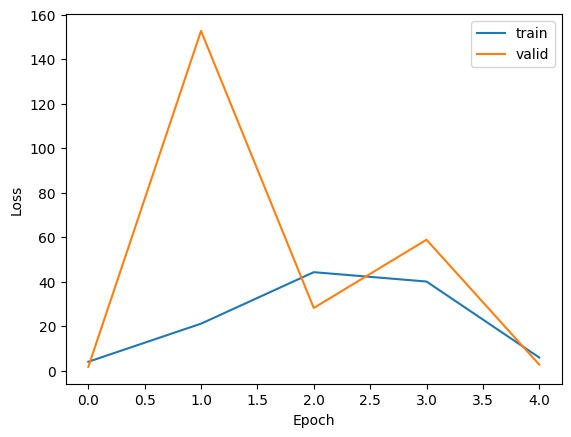

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [14]:
print("Loading vision and text encoders...")
vision_encoder = keras.models.load_model("vision_encoder")
text_encoder = keras.models.load_model("text_encoder")
print("Models are loaded.")


def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return tf.image.resize(image_array, (299, 299))


print(f"Generating embeddings for {len(image_paths)} images...")
image_embeddings = vision_encoder.predict(
    tf.data.Dataset.from_tensor_slices(image_paths).map(read_image).batch(batch_size),
    verbose=1,
)
print(f"Image embeddings shape: {image_embeddings.shape}.")

Loading vision and text encoders...
Models are loaded.
Generating embeddings for 82783 images...
8279/8279 [==============================] - 1396s 169ms/step
Image embeddings shape: (82783, 256).


In [15]:
def find_matches(image_embeddings, queries, k=9, normalize=True):
    # Get the embedding for the query.
    query_embedding = text_encoder(tf.convert_to_tensor(queries))
    # Normalize the query and the image embeddings.
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[image_paths[idx] for idx in indices] for indices in results]

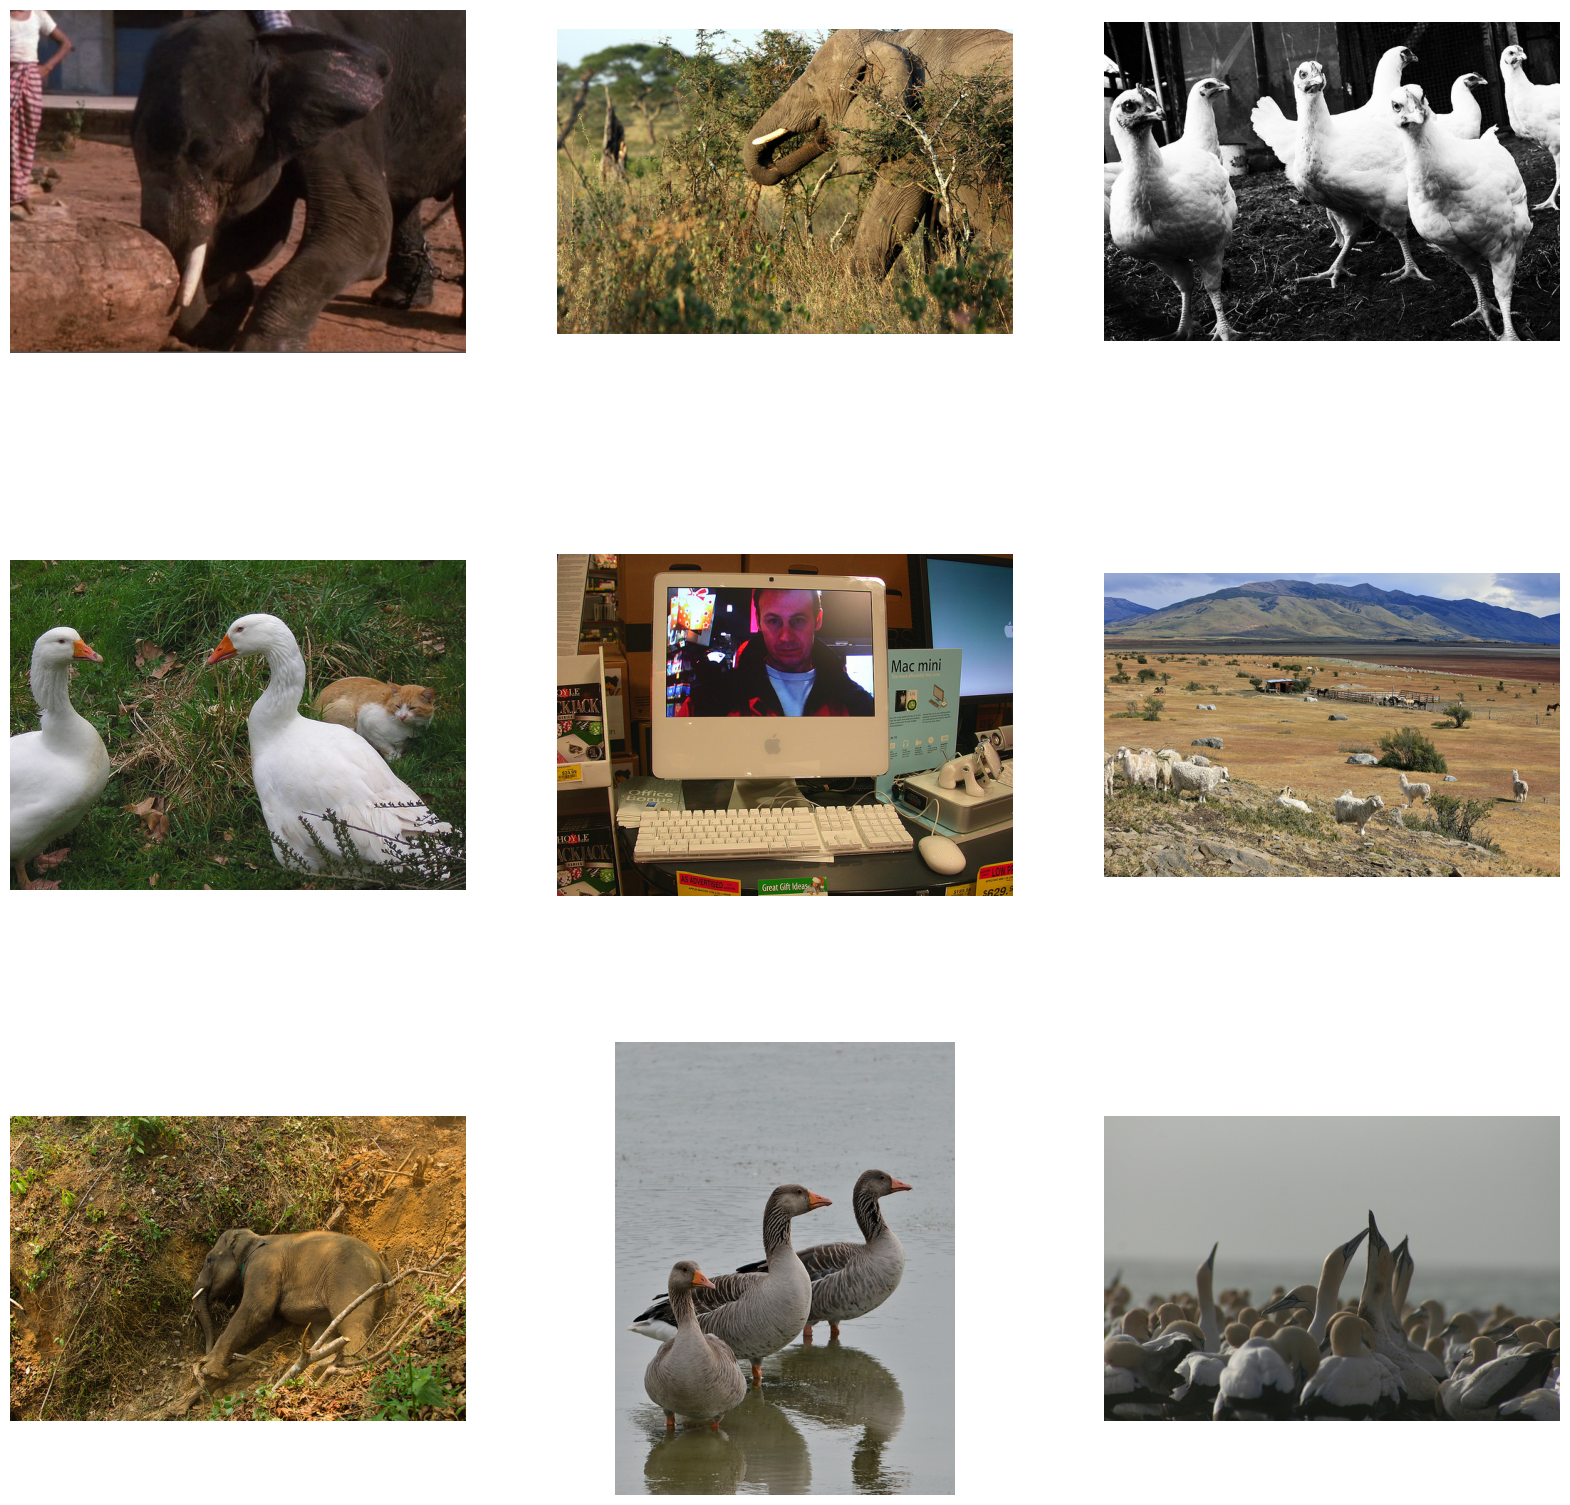

In [16]:
query = "a family standing next to the ocean on a sandy beach with a surf board"
matches = find_matches(image_embeddings, [query], normalize=True)[0]

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(matches[i]))
    plt.axis("off")

In [17]:
def compute_top_k_accuracy(image_paths, k=100):
    hits = 0
    num_batches = int(np.ceil(len(image_paths) / batch_size))
    for idx in tqdm(range(num_batches)):
        start_idx = idx * batch_size
        end_idx = start_idx + batch_size
        current_image_paths = image_paths[start_idx:end_idx]
        queries = [
            image_path_to_caption[image_path][0] for image_path in current_image_paths
        ]
        result = find_matches(image_embeddings, queries, k)
        hits += sum(
            [
                image_path in matches
                for (image_path, matches) in list(zip(current_image_paths, result))
            ]
        )

    return hits / len(image_paths)


print("Scoring training data...")
train_accuracy = compute_top_k_accuracy(train_image_paths)
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring evaluation data...")
eval_accuracy = compute_top_k_accuracy(image_paths[train_size:])
print(f"Eval accuracy: {round(eval_accuracy * 100, 3)}%")

Scoring training data...


100%|██████████████████████████████████████| 3000/3000 [05:13<00:00,  9.57it/s]


Train accuracy: 0.123%
Scoring evaluation data...


100%|██████████████████████████████████████| 5279/5279 [09:07<00:00,  9.65it/s]

Eval accuracy: 0.121%
